In [1]:
import torch
import os
import sys
import pandas as pd
import numpy as np
from accelerate import Accelerator
from transformers import RobertaForMaskedLM, AutoModel, RobertaModel, RobertaConfig
import re
import math
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from accelerate import Accelerator
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModel,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
from transformers import AutoConfig

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings

warnings.simplefilter("ignore")

In [2]:
model = RobertaModel.from_pretrained("roberta-base")
state_dict = model.state_dict()
compressed_sd = {}

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
unique = set()
for name, layer in model.named_modules():
    #     print(name)
    unique.add(re.sub(".\d+[\.]?", ".n.", name))
unique

{'',
 'embeddings',
 'embeddings.LayerNorm',
 'embeddings.dropout',
 'embeddings.position_embeddings',
 'embeddings.token_type_embeddings',
 'embeddings.word_embeddings',
 'encoder',
 'encoder.layer',
 'encoder.layer.n.',
 'encoder.layer.n.attention',
 'encoder.layer.n.attention.output',
 'encoder.layer.n.attention.output.LayerNorm',
 'encoder.layer.n.attention.output.dense',
 'encoder.layer.n.attention.output.dropout',
 'encoder.layer.n.attention.self',
 'encoder.layer.n.attention.self.dropout',
 'encoder.layer.n.attention.self.key',
 'encoder.layer.n.attention.self.query',
 'encoder.layer.n.attention.self.value',
 'encoder.layer.n.intermediate',
 'encoder.layer.n.intermediate.dense',
 'encoder.layer.n.intermediate.intermediate_act_fn',
 'encoder.layer.n.output',
 'encoder.layer.n.output.LayerNorm',
 'encoder.layer.n.output.dense',
 'encoder.layer.n.output.dropout',
 'pooler',
 'pooler.activation',
 'pooler.dense'}

In [4]:
#  prefix = "roberta"
# compressed_sd['embeddings.position_ids'] = state_dict['embeddings.position_ids']
for w in ["word_embeddings", "position_embeddings", "token_type_embeddings"]:
    param_name = f"embeddings.{w}.weight"
    compressed_sd[param_name] = state_dict[param_name]
for w in ["weight", "bias"]:
    param_name = f"embeddings.LayerNorm.{w}"
    compressed_sd[param_name] = state_dict[param_name]

In [5]:
std_idx = 0
for teacher_idx in [0, 2, 4, 7, 9, 11]:
    for layer in [
        "attention.self.query",
        "attention.self.key",
        "attention.self.value",
        "attention.output.dense",
        "attention.output.LayerNorm",
        "intermediate.dense",
        "output.dense",
        "output.LayerNorm",
    ]:
        for w in ["weight", "bias"]:
            compressed_sd[f"encoder.layer.{std_idx}.{layer}.{w}"] = state_dict[
                f"encoder.layer.{teacher_idx}.{layer}.{w}"
            ]
    std_idx += 1

In [6]:
for layer in ["pooler.dense.weight", "pooler.dense.bias"]:
    compressed_sd[f"{layer}"] = state_dict[f"{layer}"]

In [7]:
print(f"Number of params transferred for distillation: {len(compressed_sd.keys())}")

Number of params transferred for distillation: 103


In [8]:
config = RobertaConfig.from_pretrained("roberta-base", num_hidden_layers=6)

In [9]:
config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [10]:
model_student = AutoModel.from_config(config=config)

In [11]:
torch.save(compressed_sd, "roberta_base_6layers.pth")

In [12]:
set(compressed_sd.keys()) - set(model_student.state_dict().keys())

set()

In [13]:
model_student.load_state_dict(compressed_sd)

<All keys matched successfully>

In [14]:
param_size = 0
for param in model_student.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print("model size: {:.3f}MB".format(size_all_mb))

model size: 313.265MB


In [15]:
model_student.save_pretrained("roberta_base_6layers_student", from_pt=True)

In [16]:
model_check = RobertaModel.from_pretrained(
    "/kaggle/working/roberta_base_6layers.pth", config=config
)

In [17]:
!ls ../working/roberta_base_6layers_student

config.json  model.safetensors


In [18]:
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

**You Can Further Train it**

In [19]:
EPOCHS = 5
lr = 1e-3
SEED = 42
MAX_LEN = 128
BATCH_SIZE = 64
accumulation_steps = 2


data_path = "../input/data-for-distilation"
train = pd.read_csv("../input/data-for-distilation/Clinc_Train.csv")
valid = pd.read_csv("../input/data-for-distilation/Clinc_valid.csv")
n_classes = np.unique(train.Target).shape[0]
train.head(2)

,Text,Target,intent
0,what expression would i use to say i love you ...,61,translate
1,can you tell me how to say 'i do not speak muc...,61,translate


In [20]:
class ClinicModel(nn.Module):
    def __init__(self, config, model):
        super(ClinicModel, self).__init__()
        self.model = model
        self.output = nn.Linear(768, n_classes)

    def forward(self, ids, mask):
        sequence_output = self.model(ids, mask).last_hidden_state[:, 0, :]
        #         sequence_output = sequence_output[:, 0, :]
        logits = self.output(sequence_output)
        return logits


train_texts = train["Text"].values.tolist()
val_texts = valid["Text"].values.tolist()
train_labels = train["Target"].values.tolist()
val_labels = valid["Target"].values.tolist()
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


class ClinicDatasetV2(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return {
            "ids": item.get("input_ids"),
            "mask": item.get("attention_mask"),
            "labels": item.get("labels"),
        }

    def __len__(self):
        return len(self.labels)


train_loader = torch.utils.data.DataLoader(
    ClinicDatasetV2(train_encodings, train_labels),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    ClinicDatasetV2(val_encodings, val_labels),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)


def valid_func(model, val_loader, val_bar):
    model.eval()
    #     bar = tqdm(valid_loader,file=sys.stdout)
    loss_fn = torch.nn.CrossEntropyLoss()
    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    for batch_idx, data in enumerate(val_loader):
        val_bar.update(1)
        input_ids = data["ids"].cuda()
        input_masks = data["mask"].cuda()
        targets = data["labels"].long().view(-1).cuda()
        with torch.no_grad():
            logits = model(input_ids, input_masks)

        PREDS += [torch.argmax(logits, 1).detach().cpu()]
        TARGETS += [targets.detach().cpu()]

        loss = loss_fn(logits, targets)
        losses.append(loss.item())
        val_bar.set_description(f'step: {batch_idx+1} loss: {"%.4f" % loss}')

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    accuracy = (PREDS == TARGETS).mean()

    loss_valid = np.mean(losses)
    return loss_valid, accuracy


def single_gpu(name):
    use_amp = True
    debug = False
    best_epoch_loss = np.inf

    net = ClinicModel(config, model_check)
    net.cuda()
    log_df = pd.DataFrame(
        columns=["Epoch", "Train_Loss", "Valid_Loss", "Valid_Accuracy"]
    )
    accelerator = Accelerator(
        log_with="tensorboard", project_dir=".", mixed_precision="fp16"
    )
    #     accelerator = Accelerator(mixed_precision='bf16')
    Config = {
        "num_epoch": EPOCHS,
        "learning_rate": lr,
        "loss_function": str(torch.nn.CrossEntropyLoss),
    }

    accelerator.init_trackers(f"{name}_project", config=Config)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = AdamW(net.parameters(), lr=lr)
    num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.05 * num_train_optimization_steps,
        num_training_steps=num_train_optimization_steps,
    )  # PyTorch scheduler
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()
    epoch_check = len(train_loader)
    total_step = epoch_check * EPOCHS
    train_bar = tqdm(total=total_step, dynamic_ncols=True)
    val_bar = tqdm(total=len(val_loader), leave=True, dynamic_ncols=True)
    t_step = 1
    for epoch in range(5):
        avg_loss = 0.0
        net.train()
        loss_list = []
        for step, data in enumerate(train_loader):
            train_bar.update(1)
            #         train_bar.set_description(f"step: {i+1} epoch: {epoch+1}")
            input_ids = data["ids"].cuda()
            input_masks = data["mask"].cuda()
            targets = data["labels"].long().view(-1).cuda()
            with torch.cuda.amp.autocast():
                pred = net(input_ids, input_masks)
            loss = loss_fn(pred, targets)
            scaler.scale(loss).backward()
            if step % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            accelerator.log({"training_loss_step": loss}, step=t_step)
            t_step += 1

            loss_list.append(loss.detach().cpu().item())
        scheduler.step()
        avg_loss = np.round(np.mean(loss_list), 4)
        accelerator.log({"train_epoch": avg_loss}, step=epoch)
        vloss, vaccuracy = valid_func(net, val_loader, val_bar)
        accelerator.log({"vloss_epoch": loss}, step=epoch)
        accelerator.log({"vaccuracy_epoch": vaccuracy}, step=epoch)
        print(f'Epoc: {epoch} loss: {"%.4f" % vloss},accuracy: {"%.4f" % vaccuracy}')
        val_bar.reset()
    accelerator.end_training()

In [21]:
single_gpu(name="distilation_v1")

2024-04-29 15:48:31.181576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-04-29 15:48:31.181722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-04-29 15:48:31.308632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoc: 0 loss: 5.0520,accuracy: 0.0065

Epoc: 1 loss: 0.8956,accuracy: 0.8403

Epoc: 2 loss: 0.3374,accuracy: 0.9277

Epoc: 3 loss: 0.3097,accuracy: 0.9297

Epoc: 4 loss: 0.3538,accuracy: 0.9287


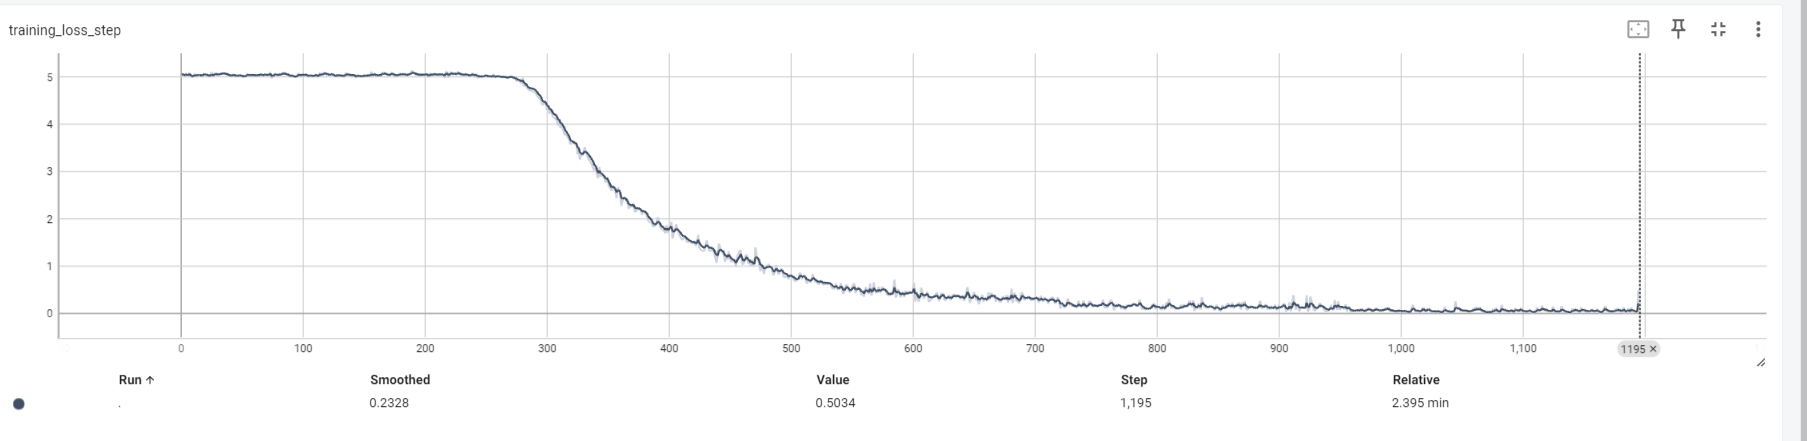

In [1]:
from PIL import Image

Image.open("../input/vyom-ai-images/Distilation_v1.png").convert("RGB")